In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors



In [6]:
from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos utiles para evaluar el modelo 
from sklearn.model_selection import train_test_split # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

Data loading and cleaning

Cual es el sitio que mas trafico me aporta en relacion a conversion?
Cual es el efecto de el medio en el que navegan en la tasa de conversion?
Sessions with Transactions per Device
What channels contribute the most?
What route(s) do visitors that buy actually take?
How many pages does it take them to convert?

Calculate the average conversion rate per browser
Find out what browser versions perform the worst

Cargamos los datos y luego de un analisis exploratorio vemos (aunque ya lo sabiamos) que hay varias columnas con NANs. Las completamos con 0.

In [35]:
fileName = 'data.csv'
data = pd.read_csv(fileName, sep = ",")
data.fillna({'bounces' : 0,'timeOnSite':0, 'transactionRevenue':0,'transactions':0, "pageViews":0}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             392892 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392856 non-null  float64
 6   timeOnSite          392892 non-null  float64
 7   transactionRevenue  392892 non-null  float64
 8   transactions        392892 non-null  float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
dtypes: float64(5), int64(3), object(7)

In [36]:
data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
data

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
0,8533875475515924645,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Australia,Sydney
1,4874599869430831185,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,mobile,Turkey,Istanbul
2,361954421372951638,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Russia,Moscow
3,8751850432978942600,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,bing,Organic Search,Edge,desktop,United States,not available in demo dataset
4,2451058030378352110,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Indonesia,not available in demo dataset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392887,4823772839168317708,1,2017-03-14,0.0,14,10.0,210.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Australia,Sydney
392888,4495028198726387872,1,2017-03-14,0.0,15,13.0,306.0,0.00,0.0,m.facebook.com,Social,Android Webview,mobile,United States,not available in demo dataset
392889,659863211325608630,1,2017-03-14,0.0,16,16.0,202.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Colombia,not available in demo dataset
392890,5989424100079269693,1,2017-03-14,0.0,20,18.0,621.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Israel,Tel Aviv-Yafo


Transformo las variables categoricas a numeros para ver que onda en el analisis de correlacion. Tiene senti

In [37]:
data.channelGrouping.unique()
channels = {'Organic Search':1, 'Direct':2, 'Referral':3, 'Paid Search':4,
       'Affiliates':5, 'Display':6, 'Social':7, '(Other)':8}
data.channelGrouping= data.channelGrouping.map(channels)


In [38]:
devices = {'desktop':1, 'mobile':2, 'tablet':3}
data.deviceCategory= data.deviceCategory.map(devices)
data

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
0,8533875475515924645,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),1,Chrome,1,Australia,Sydney
1,4874599869430831185,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),1,Chrome,2,Turkey,Istanbul
2,361954421372951638,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),1,Chrome,1,Russia,Moscow
3,8751850432978942600,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,bing,1,Edge,1,United States,not available in demo dataset
4,2451058030378352110,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),1,Chrome,1,Indonesia,not available in demo dataset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392887,4823772839168317708,1,2017-03-14,0.0,14,10.0,210.0,0.00,0.0,youtube.com,7,Chrome,1,Australia,Sydney
392888,4495028198726387872,1,2017-03-14,0.0,15,13.0,306.0,0.00,0.0,m.facebook.com,7,Android Webview,2,United States,not available in demo dataset
392889,659863211325608630,1,2017-03-14,0.0,16,16.0,202.0,0.00,0.0,youtube.com,7,Chrome,1,Colombia,not available in demo dataset
392890,5989424100079269693,1,2017-03-14,0.0,20,18.0,621.0,0.00,0.0,youtube.com,7,Chrome,1,Israel,Tel Aviv-Yafo


In [39]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
visitNumber,392892.0,2.361198,10.158865,1.0,1.0,1.0,1.0,389.00
bounces,392892.0,0.498773,0.499999,0.0,0.0,0.0,1.0,1.00
hits,392892.0,4.414065,8.555069,1.0,1.0,2.0,4.0,500.00
pageviews,392856.0,3.771015,6.414908,1.0,1.0,1.0,4.0,466.00
timeOnSite,392892.0,138.385447,370.290633,0.0,0.0,0.0,94.0,12136.00
transactionRevenue,392892.0,2.187108,105.837010,0.0,0.0,0.0,0.0,47082.06
transactions,392892.0,0.014073,0.137584,0.0,0.0,0.0,0.0,25.00
channelGrouping,392892.0,2.440844,2.041314,1.0,1.0,2.0,3.0,8.00
deviceCategory,392892.0,1.358480,0.554949,1.0,1.0,1.0,2.0,3.00


<AxesSubplot:>

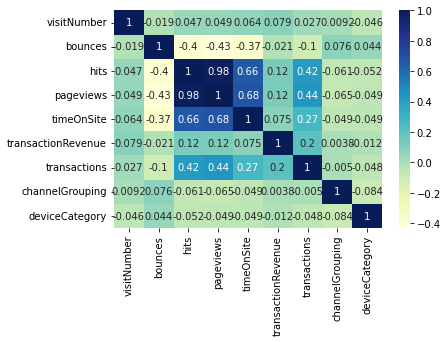

In [40]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

In [32]:
data['login_month'] = data['date'].dt.to_period('M')
data['cohort'] = data.groupby('fullVisitorID')['date'].transform('min').dt.to_period('M') 

In [33]:
data

,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city,login_month,cohort,login_week
0,8533875475515924645,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Australia,Sydney,2017-02,2017-02,2017-01-30/2017-02-05
1,4874599869430831185,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,mobile,Turkey,Istanbul,2017-02,2017-02,2017-01-30/2017-02-05
2,361954421372951638,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Russia,Moscow,2017-02,2017-02,2017-01-30/2017-02-05
3,8751850432978942600,2,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,bing,Organic Search,Edge,desktop,United States,not available in demo dataset,2017-02,2017-02,2017-01-30/2017-02-05
4,2451058030378352110,1,2017-02-05,1.0,1,1.0,0.0,0.00,0.0,(direct),Organic Search,Chrome,desktop,Indonesia,not available in demo dataset,2017-02,2017-02,2017-01-30/2017-02-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392887,4823772839168317708,1,2017-03-14,0.0,14,10.0,210.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Australia,Sydney,2017-03,2017-03,2017-03-13/2017-03-19
392888,4495028198726387872,1,2017-03-14,0.0,15,13.0,306.0,0.00,0.0,m.facebook.com,Social,Android Webview,mobile,United States,not available in demo dataset,2017-03,2017-03,2017-03-13/2017-03-19
392889,659863211325608630,1,2017-03-14,0.0,16,16.0,202.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Colombia,not available in demo dataset,2017-03,2017-03,2017-03-13/2017-03-19
392890,5989424100079269693,1,2017-03-14,0.0,20,18.0,621.0,0.00,0.0,youtube.com,Social,Chrome,desktop,Israel,Tel Aviv-Yafo,2017-03,2017-03,2017-03-13/2017-03-19


In [34]:
df_cohort = data.groupby(['cohort', 'login_month']).agg(n_customers=('fullVisitorID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.login_month - df_cohort.cohort).apply(attrgetter('n'))

df_cohort

,cohort,login_month,n_customers,period_number
0,2017-01,2017-01,55527,0
1,2017-01,2017-02,1743,1
2,2017-01,2017-03,760,2
3,2017-01,2017-04,453,3
4,2017-01,2017-05,321,4
5,2017-01,2017-06,237,5
6,2017-02,2017-02,51887,0
7,2017-02,2017-03,1351,1
8,2017-02,2017-04,459,2
9,2017-02,2017-05,332,3


In [35]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [36]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

retention_matrix

period_number,0,1,2,3,4,5
cohort,,,,,,
2017-01,1.0,0.031390,0.013687,0.008158,0.005781,0.004268
2017-02,1.0,0.026037,0.008846,0.006399,0.003643,NaN
2017-03,1.0,0.022964,0.009035,0.004381,NaN,NaN
2017-04,1.0,0.026374,0.008057,NaN,NaN,NaN
2017-05,1.0,0.026054,NaN,NaN,NaN,NaN
2017-06,1.0,NaN,NaN,NaN,NaN,NaN


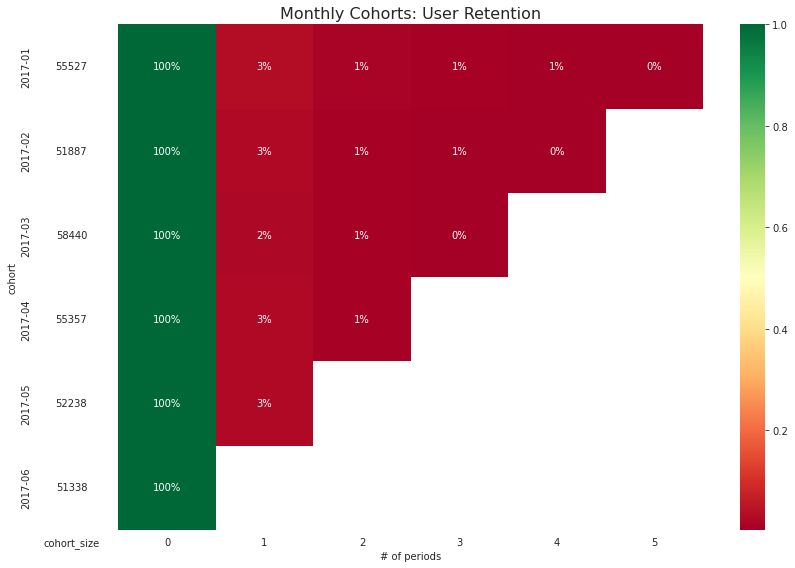

In [37]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
#Para el modelo hay que 